In [1]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [2]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [4]:
%run load_Results.py

In [52]:
wt00 = np.where(gold0 == 1, 1/.064, 1)

In [432]:
#wts01 = np.where(gold1 == 1, 1/np.mean(gold1), 1)
#wts02 = np.where(gold2 == 1, 2/np.mean(gold2), 2)
#wts03 = np.where(gold3 == 1, 3/np.mean(gold3), 3)
#wts04 = np.where(gold4 == 1, 4/np.mean(gold4), 4)

In [472]:
wts01 = np.where(gold1 == 1, 1/.064, 1)
wts02 = np.where(gold2 == 1, 2/.064, 2)
wts03 = np.where(gold3 == 1, 3/.064, 3)
wts04 = np.where(gold4 == 1, 4/.064, 4)

In [473]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )

time_index = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
test_time_index = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [474]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits + t[1]) /  t [0]
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x

In [475]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)


In [476]:
def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit + alpha[1])/ alpha[0]     
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [477]:
cal_0_1234 = temp_pred2(alpha_0_1234, lo1234 )

In [478]:
cal_t_1234 = temp_pred2(alpha_0_1234, tlo1234 )

(array([13501., 12610.,  8878.,  6941.,  5396.,  3528.,  2228.,  1287.,
          437.,    62.]),
 array([0.02039217, 0.08959543, 0.15879868, 0.22800194, 0.2972052 ,
        0.36640846, 0.43561172, 0.50481497, 0.57401823, 0.64322149,
        0.71242475]),
 <BarContainer object of 10 artists>)

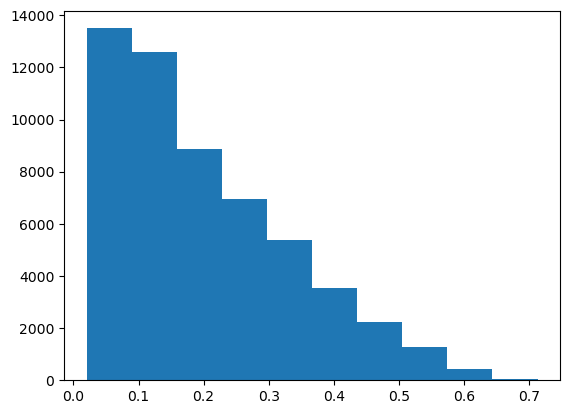

In [479]:
plt.hist(cal_t_1234)

In [480]:
w01 = 1/cal_0_1234 [time_index==1]
w02 = 1/cal_0_1234 [time_index==2]
w03 = 1/cal_0_1234 [time_index==3]
w04 = 1/cal_0_1234 [time_index==4]

In [482]:
wts1 =  w01
wts2 =  w02
wts3 =  w03
wts4 =  w04

In [483]:
max(wts4)

48.13788537819187

In [484]:
wts1 = np.where(gold1 == 1, w01/np.mean(gold1), w01)
wts2 = np.where(gold2 == 1, w02/np.mean(gold2), w02)
wts3 = np.where(gold3 == 1, w03/np.mean(gold3), w03)
wts4 = np.where(gold4 == 1, w04/np.mean(gold4), w04)

In [485]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])  / t[5] 
        logi_2 = (l2 +  t[2])  / t[6] 
        logi_3 = (l3 +  t[3])  / t[7] 
        logi_4 = (l4 +  t[4])  / t[8] 
        
        p1  = expit (t[0] *  logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] * logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1,.1  ] )    
    return  r

In [486]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [487]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit   + j1) / j2     
    proba = expit (  logi *tt.x[0]  )  
    return proba

In [499]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 1000)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 1000)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 1000)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 1000)



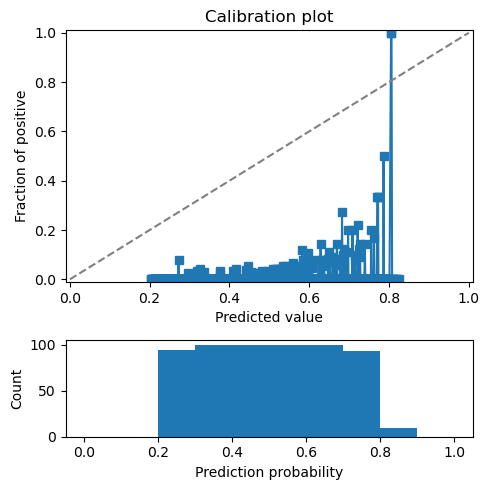

In [500]:
plotter(p4, y4)

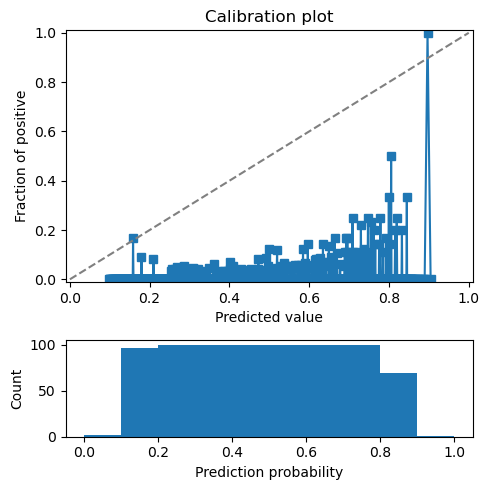

In [501]:
plotter(p3, y3)

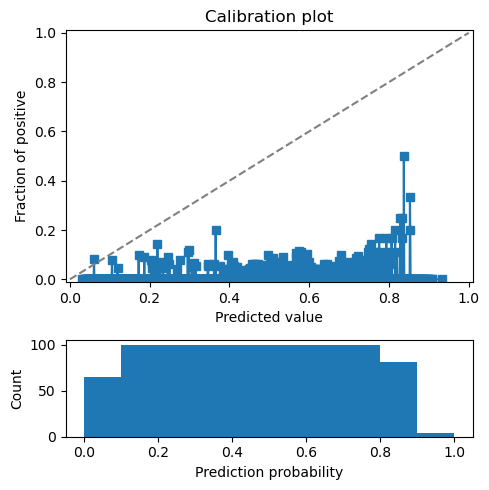

In [502]:
plotter(p2, y2)

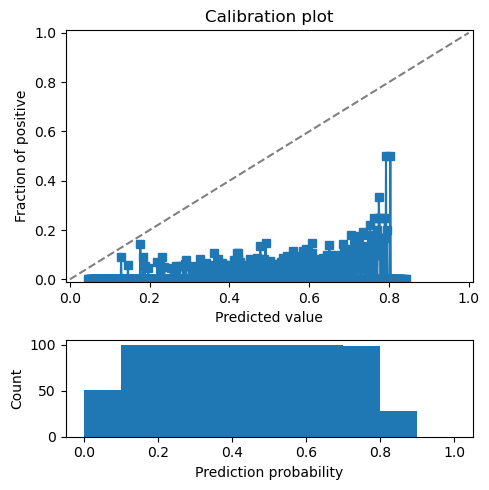

In [503]:
plotter(p1, y1)

In [497]:
def temperature_multi_5(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])    
        logi_2 = (l2 +  t[2])   
        logi_3 = (l3 +  t[3])  
        logi_4 = (l4 +  t[4])   
        
        p1  = expit (  logi_1/ t[0]  )  
        p2  = expit (  logi_2/ t[0]  )  
        p3  = expit ( logi_3/ t[0]   )  
        p4  = expit ( logi_4 /t[0] ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+ log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, .1  ] )    
    return  r

In [163]:
tt5  = temperature_multi_5( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [164]:
def temp_pred5  ( j1, test_logit):    
    logi =  ( test_logit   + j1)   
    proba = expit (  logi / tt.x[0]  )  
    return proba

(array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 array([0.00108184, 0.10083033, 0.20057882, 0.30032731, 0.4000758 ,
        0.49982429, 0.59957278, 0.69932127, 0.79906976, 0.89881825,
        0.99856674]),
 <BarContainer object of 10 artists>)

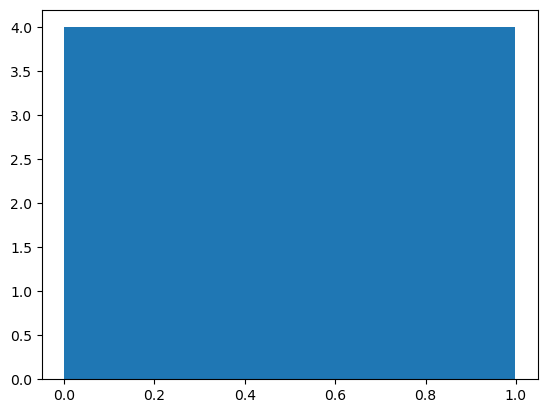

In [165]:
cal_1 = temp_pred5(tt.x[1] , logit(tp1) )
cal_2 = temp_pred5(tt.x[2],  logit(tp2) )
cal_3 = temp_pred5(tt.x[3],  logit(tp3) )
cal_4 = temp_pred5(tt.x[4], logit(tp4) )

y1, p1 = compute_calibration_curve(M_test1['golds'], cal_1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal_2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal_3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal_4 )


plt.hist(p4)

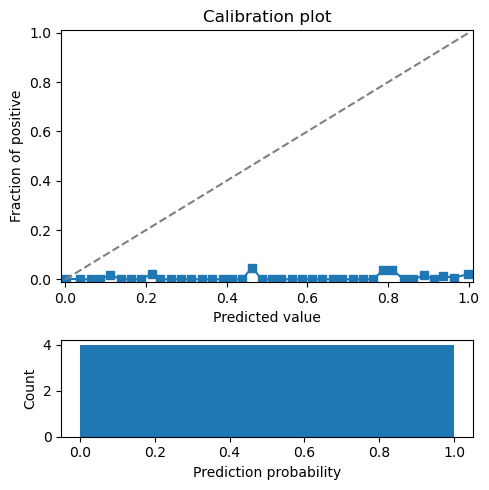

In [168]:
plotter(p4, y4)

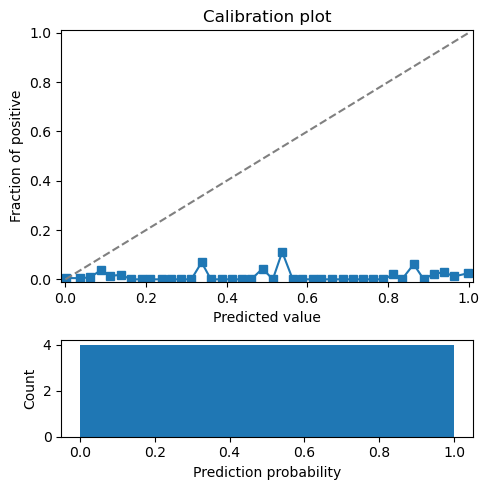

In [166]:
plotter(p3, y3)

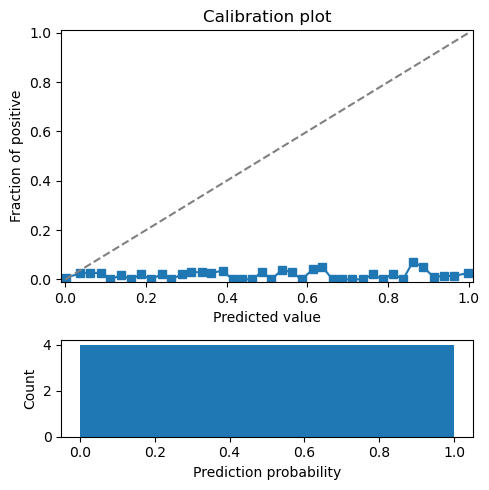

In [167]:
plotter(p2, y2)

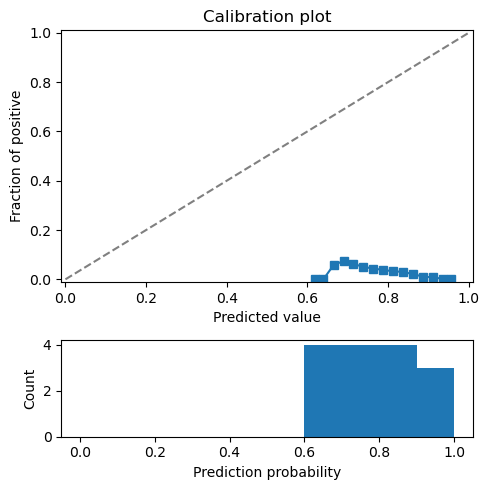

In [92]:
plotter(p1, y1)

In [20]:
import sklearn
from sklearn.metrics import confusion_matrix

In [224]:
sklearn.metrics.roc_auc_score(tgold3,  tc3 , average = 'samples')


0.6854529873329583

In [230]:
sklearn.metrics.roc_auc_score(tgold4,  tc4 , average = 'samples')


0.7072423069302404

In [225]:
sklearn.metrics.roc_auc_score(tgold1,  tc1 , average = 'samples')


0.6480031999535442

In [226]:
( confusion_matrix (tgold1,  tc1>.5) )

array([[8111, 7408],
       [ 145,  361]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [231]:
( confusion_matrix (tgold1,  tp1>.05) )

array([[ 1657, 13862],
       [   10,   496]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [67]:
def temperature_multi_w5 (l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])  
        logi_2 = (l2 +  t[2])   
        logi_3 = (l3 +  t[3])   
        logi_4 = (l4 +  t[4])  
        
        p1  = expit (t[0]*   logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] *  logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+ log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1 ] )    
    return  r

In [68]:
tt  = temperature_multi_w5( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [70]:
def temp_pred  ( j1, test_logit):    
    logi =  ( test_logit   + j1)   
    proba = expit ( tt.x[0] * logi   )  
    return proba

In [71]:
cal_1 = temp_pred(tt.x[1] , logit(tp1) )
cal_2 = temp_pred(tt.x[2],  logit(tp2) )
cal_3 = temp_pred(tt.x[3],  logit(tp3) )
cal_4 = temp_pred(tt.x[4],  logit(tp4) )

In [72]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal_1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal_2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal_3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal_4 )


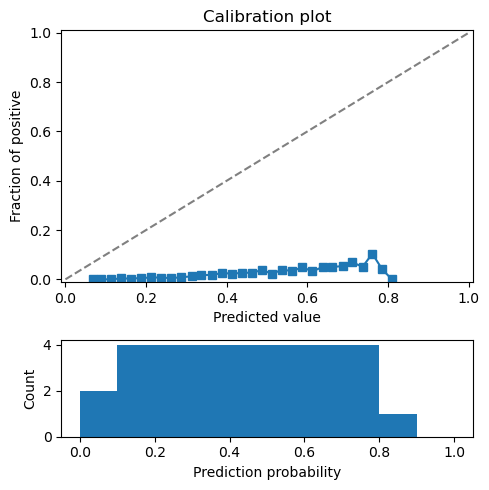

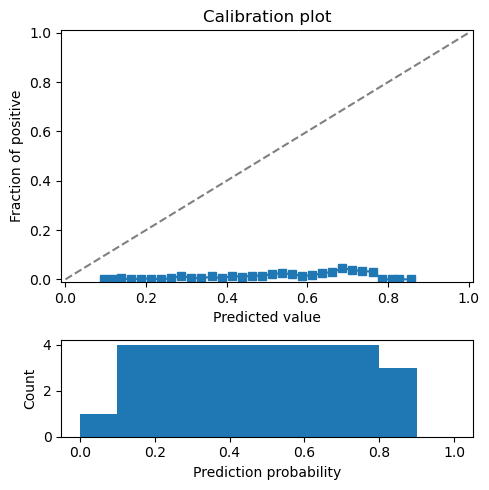

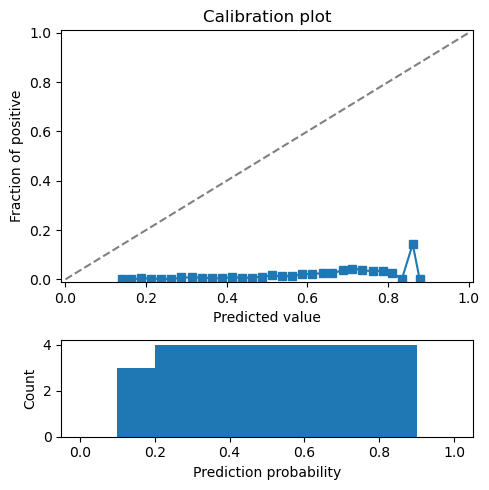

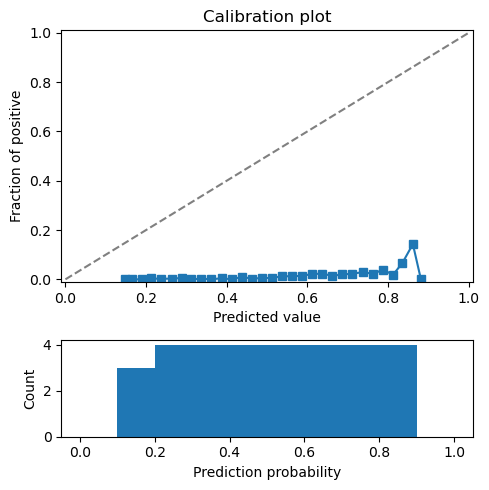

In [73]:
plotter(p1, y1)
plotter(p2, y2)
plotter(p3, y3)
plotter(p4, y4)